Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import classification_report, confusion_matrix

Start by loading both csv files into pandas dataframe

# Preprocessing

In [2]:
users = pd.read_csv('takehome_users.csv', encoding = 'latin-1') #Encoding is used otherwise we get an error when loading data
engage = pd.read_csv('takehome_user_engagement.csv', encoding = 'latin-1') # Other possible values are 'iso-8859-1' or 'cp1252'

In [3]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Creation_time and Last_session_creation_time should be datetimes datatypes if we are looking to analyze that data

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


We don't need the names and email of the clients in order analyze their potential for further use

In [6]:
engage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


Visited column is 1 for every row and is can be removed since it doesnt really tell us anything

In [7]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Time_stamp also needs to be a datatime datatype

In [8]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


We can see that for user dataframe we have the column creation_time and last_session_creation_time listed as an object data type.  Also, the engage dataframe has time_stamp as an object as well.  We need to convert them to datetime objects.  Also, the object_id in users should be changed to user_id since that is what is being used in the other dataframe.

In [9]:
#Convert to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])

#Rename object_id to user_id
users.rename(columns = {'object_id' : 'user_id'}, inplace = True)

#Last_session_creation_time is a unix timestamp so we need convert using a different method
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),na_action='ignore')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])

In [10]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 22:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 22:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 18:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 03:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 04:14:20,0,0,193,5240.0


Next we will be determining an adopted user which is defined as a user who has logged into the product on three separate days in at least one seven day period

In [11]:
# Set index to the datetime time_stamp column
engage = engage.set_index('time_stamp', drop= True)

In [12]:
# Create function to determine if user has been active within a 7-day period
def label_adopted(x):    
    adopt = engage.loc[engage['user_id'] == x] 
    adopt = adopt.resample('D').mean().dropna() 
    adopted = 0
    for i in range(len(adopt)-2): 
        if adopt.index[i + 2] - adopt.index[i] <= timedelta(days=7):
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [13]:
#Apply function to user_id in order to create new column adopted_user
users['adopted_user'] = users['user_id'].apply(label_adopted)

In [14]:
# Show number of adopted users and the percent of adopted users of the total users
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


What we see is that out of the 12000 users we have only 1656 users that are classified adopted users which is 13.8 % of all users.

For predicting future user adoption we don't need the column name, user_id, email, creation_time, last_session_creation_time.

In [15]:
# Drop name and user_id column
users.drop(['name'], axis=1, inplace=True)
users.drop(['user_id'], axis=1, inplace=True)
users.drop(['email'], axis=1, inplace=True)
users.drop(['creation_time'], axis=1, inplace=True)
users.drop(['last_session_creation_time'], axis=1, inplace=True)

# Fill NaN values as zero for column invited_by_user_id
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

In [16]:
users.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,GUEST_INVITE,1,0,11,10803.0,0
1,ORG_INVITE,0,0,1,316.0,1
2,ORG_INVITE,0,0,94,1525.0,0
3,GUEST_INVITE,0,0,1,5151.0,0
4,GUEST_INVITE,0,0,193,5240.0,0


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          12000 non-null  float64
 5   adopted_user                12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


We want to change the column creation_source so that we have number values assigned for the categories instead of names.  Extracting the names and putting them as the new title of the categories will enable use to further analyze the data

In [18]:
#Create new columns for each of the five values of creation_source
users = pd.get_dummies(users, columns = ['creation_source'])
users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0,1,0,0,0,0
1,0,0,1,316.0,1,0,1,0,0,0
2,0,0,94,1525.0,0,0,1,0,0,0
3,0,0,1,5151.0,0,1,0,0,0,0
4,0,0,193,5240.0,0,1,0,0,0,0


# Analysis

In [19]:
# Identify variables to be used for cross validation  
x = users.drop('adopted_user', axis=1)
y = users.adopted_user

# Splitting train and test sets
X_train, y_train, X_test, y_test = train_test_split(x, y, test_size=0.3, random_state=25)

In [20]:
#Use Random Forest Classifier to predict whether user is adopted or not
random = RandomForestClassifier()
random.fit(X_train, X_test)
random.score(y_train, y_test)

0.8091666666666667

In [22]:
#Generate confusion matrix and classification report
y_predict = random.predict(y_train)
print(classification_report(y_test, y_predict))
confusion = confusion_matrix(y_test, y_predict)
print('confusion matrix:')
print(confusion)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3088
           1       0.15      0.07      0.10       512

    accuracy                           0.81      3600
   macro avg       0.50      0.50      0.50      3600
weighted avg       0.76      0.81      0.78      3600

confusion matrix:
[[2875  213]
 [ 474   38]]


Accuracy for our model is pretty high despite the fact that number of adopted users is far less than the unadopted users.  This shows that the features that the model has chosen will be extremely important.

In [23]:
#Create new dataframe that lists the feature importance of the Random Forest Classifier sorted by highest coefficient
feature_importance = pd.DataFrame()
feature_importance['Coefficient'] = random.feature_importances_
feature_importance = feature_importance.set_index(x.columns)
feature_importance.Coefficient.nlargest(10)

org_id                                0.610617
invited_by_user_id                    0.342643
opted_in_to_mailing_list              0.014161
enabled_for_marketing_drip            0.013197
creation_source_PERSONAL_PROJECTS     0.005702
creation_source_GUEST_INVITE          0.004131
creation_source_ORG_INVITE            0.004030
creation_source_SIGNUP_GOOGLE_AUTH    0.002937
creation_source_SIGNUP                0.002581
Name: Coefficient, dtype: float64

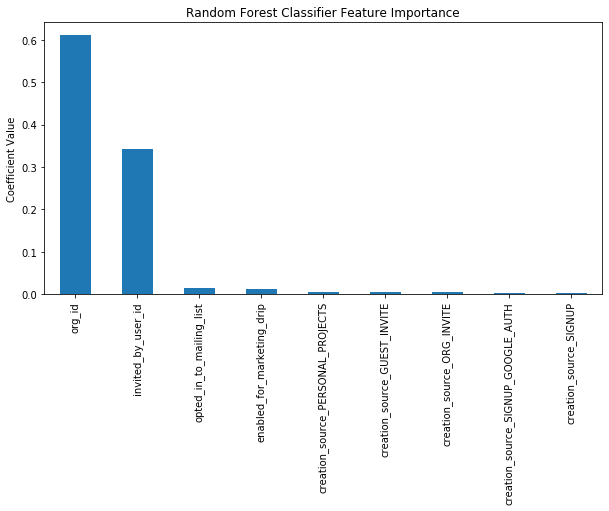

In [24]:
#Plot the results
plt.figure(figsize=(10,5))
(feature_importance['Coefficient']).nlargest(10).plot(kind='bar', x = feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('Coefficient Value')
plt.show()

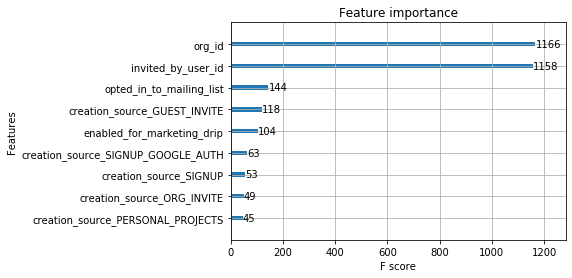

In [25]:
#Create XGBoost model to compare against the Random Forest Classifier
model = XGBClassifier()
model.fit(x, y)
plot_importance(model)
pyplot.show()

As we can see both Random Forest Classifier and XGBoost show are most important factors are org_id and invited_by_user_id.  This means that the company the users works for and whether or not if they were invited by another users are the most influential towards creating an adopted user.